# RPA 작업

### Load libaries

In [ ]:
import winreg
import os
import win32com.client as win32
from PyPDF2 import PdfMerger
import pandas as pd
from tqdm import tqdm
import os
import numpy as np

### Intial Settings

- SECURE_MODULE_PATH : 스크립트로 한글파일 편집 시 경고창이 뜨는데, 이를 막기 위해 보안모듈을 다운받고, 레지스트리 편집기에 경로를 등록해주어야 함. 이 때 보안모듈을 다운받은 경로
- REGISTERY_KEY_NAME : 레지스트리에 보안모듈 경로 등록할 키
- HWP_DOC_DIR : 사업방법서 한글파일을 모아둔 폴더의 경로
- LIST_FILE_PATH, SHEET_NAME : 주계약, 독립특약 Mapping을 적어은 엑셀파일 경로와 시트명
- WORKING_DIR : 작업파일을 저장할 폴더 경로
- OUTPUT_DIR : 결과파일을 저장할 폴더 경로
- SAVE_HWP : 글씨색깔을 변경한 한글문서를 저장할지 여부

In [ ]:
SECURE_MODULE_PATH = "./security_module/FilePathCheckerModuleExample.dll"
REGISTERY_KEY_NAME = "AutomationModule"
HWP_DOC_DIR = "./input/hwp"
LIST_FILE_PATH = "./input/list.xlsx"
SHEET_NAME = "list"
WORKING_DIR = "./working"
OUTPUT_DIR = "./output"
SAVE_HWP = False

config = {
    "registry_key_name" : REGISTERY_KEY_NAME,
    "hwp_doc_dir" : HWP_DOC_DIR,
    "list_file_path" : LIST_FILE_PATH,
    "sheet_name" : SHEET_NAME,
    "working_dir" : WORKING_DIR,
    "output_dir" : OUTPUT_DIR,
    "save_hwp" : SAVE_HWP,
}

### Set Registry Key

레지스트리 편집기에 아래와 같이 보안모듈 경로를 키로 등록해주어야 해야 함

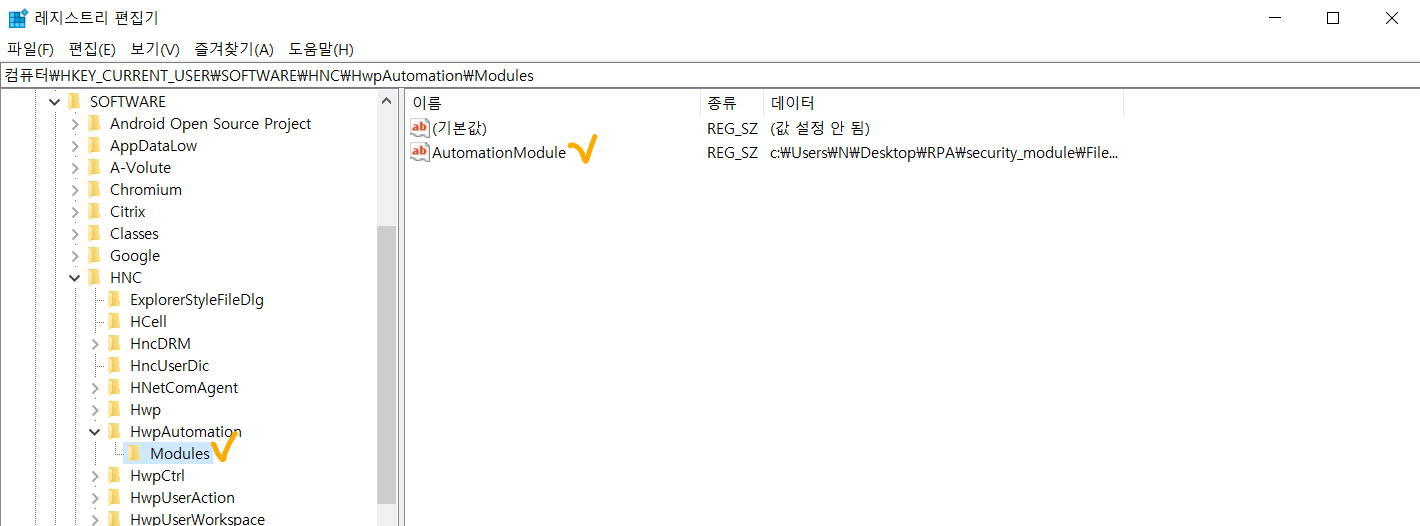

In [ ]:
winup_path = "Software\HNC\HwpAutomation\Modules"
winreg.CreateKey(winreg.HKEY_CURRENT_USER, winup_path)
key_path = winreg.OpenKey(winreg.HKEY_CURRENT_USER, winup_path,  0, winreg.KEY_ALL_ACCESS)
winreg.SetValueEx(key_path, REGISTERY_KEY_NAME, 0, winreg.REG_SZ, os.path.abspath(SECURE_MODULE_PATH))
winreg.CloseKey(key_path)

### Util

In [ ]:
class Util:

    @staticmethod
    def open_hwp_doc(hwp_file_path: str, registry_key_name : str) -> any:
        hwp = win32.gencache.EnsureDispatch("HWPFrame.HwpObject")
        try:
            hwp.RegisterModule('FilePathCheckDLL', registry_key_name)   # register secure module
            hwp.XHwpWindows.Item(0).Visible = False                     # run background
            hwp.Open(os.path.abspath(hwp_file_path))                    # open hwp doc
            return hwp
        except:
            hwp.Quit()
            raise RuntimeError("Error occurs while opening hwp file")

    @staticmethod
    def save_hwp_doc(hwp, save_path) -> None:
        hwp.SaveAs(os.path.abspath(save_path))

    @staticmethod
    def close_hwp_doc(hwp) -> None:
        hwp.XHwpDocuments.Close(isDirty=False)
        hwp.Quit()

    @staticmethod
    def change_text_color(hwp: any) -> None:
        # red → black
        option = hwp.HParameterSet.HFindReplace
        hwp.HAction.GetDefault("AllReplace", option.HSet)
        option.FindString = ""
        option.ReplaceString = ""
        option.IgnoreMessage = 1
        option.FindCharShape.TextColor = hwp.RGBColor(255, 0, 0)
        option.ReplaceCharShape.TextColor = hwp.RGBColor(0, 0, 0)
        hwp.HAction.Execute("AllReplace", option.HSet)
        
        # blue → black
        option = hwp.HParameterSet.HFindReplace
        hwp.HAction.GetDefault("AllReplace", option.HSet)
        option.FindString = ""
        option.ReplaceString = ""
        option.IgnoreMessage = 1
        option.FindCharShape.TextColor = hwp.RGBColor(0, 0, 255)
        option.ReplaceCharShape.TextColor = hwp.RGBColor(0, 0, 0)
        hwp.HAction.Execute("AllReplace", option.HSet)

    @staticmethod
    def convert_hwp_to_pdf(hwp, path_to_save_pdf, printmethod=0) -> None:
        action = hwp.CreateAction("Print")
        print_setting = action.CreateSet()
        action.GetDefault(print_setting)
        print_setting.SetItem("PrintMethod", printmethod)
        print_setting.SetItem("FileName", os.path.abspath(path_to_save_pdf))
        print_setting.SetItem("PrinterName", "Microsoft Print to PDF")
        action.Execute(print_setting)

    @staticmethod
    def merge_pdf(pdf_files: list, save_file_path: str) -> None:
        pdf_merger = PdfMerger(strict=False)
        for file in pdf_files:
            pdf_merger.append(file)
        pdf_merger.write(save_file_path)
        pdf_merger.close()

### Main Class

In [ ]:
class Rpa(Util):
    def __init__(cls, hwp_doc_dir, list_file_path, sheet_name, output_dir, working_dir, registry_key_name, prefix="001_", suffix="_공시용", save_hwp=False):
        cls.hwp_doc_dir = os.path.abspath(hwp_doc_dir)
        cls.list_file_path = os.path.abspath(list_file_path)
        cls.sheet_name = sheet_name
        cls.output_dir = os.path.abspath(output_dir)
        cls.working_dir = os.path.abspath(working_dir)
        cls.registry_key_name = registry_key_name
        cls.prefix = prefix
        cls.suffix = suffix
        cls.save_hwp = save_hwp
                            
        cls.prod_mapping = {}                             
        cls.filename_mapping = {}

    def main(cls):
        print("Cheking inputs....")
        cls.check_folder_exist()

        print("Set mappings...")
        cls.set_mappings()

        print("modify hwp documents...")
        cls.modify_hwp_docs()

        print("merging pdf files...")
        cls.merge_pdf_files_by_mapping()

    def check_folder_exist(cls):
        if not os.path.exists(cls.list_file_path):
            raise ValueError("Excel file path is not vallid...")
        if not os.path.exists(cls.hwp_doc_dir):
            raise ValueError("Directory for hwp docs is not vallid...")
        if not os.path.exists(cls.working_dir):
            os.mkdir(path=cls.working_dir)
        if not os.path.exists(cls.output_dir):
            os.mkdir(path=cls.output_dir)

    def set_mappings(cls):
        """
        주계약, 독립특약 Mapping 엑셀파일을 읽음
        """
        df = pd.read_excel(cls.list_file_path, sheet_name=cls.sheet_name)

        prod_codes = set()
        for prod_code in df['주계약'].values:
            prod_codes.add(prod_code)
        for prod_code in df['독립특약'].values:
            prod_codes.add(prod_code)

        cls.prod_mapping = {}
        for main_ctr in set(df['주계약'].values):
            cls.prod_mapping[main_ctr] = list(df.loc[df['주계약'] == main_ctr]['독립특약'].values)

        filenames = [f.replace(".hwp", "") for f in os.listdir(cls.hwp_doc_dir)]
        # mapping
        for prod_code in prod_codes:
            for filename in filenames:
                if filename.startswith(cls.prefix+prod_code):
                    cls.filename_mapping[prod_code] = filename
                    continue

    def modify_hwp_docs(cls):
        for prod_code in tqdm(cls.filename_mapping.keys()):
            # open hwp document
            hwp_doc_path = os.path.join(cls.hwp_doc_dir, f"{cls.filename_mapping[prod_code]}.hwp")
            hwp = cls.open_hwp_doc(hwp_doc_path, cls.registry_key_name)
            # change text color
            cls.change_text_color(hwp)
            # save documents
            if cls.save_hwp:
                cls.save_hwp_doc(hwp, os.path.join(cls.working_dir, f"{cls.filename_mapping[prod_code]}.hwp"))
            cls.convert_hwp_to_pdf(hwp, os.path.join(cls.working_dir, f"{cls.filename_mapping[prod_code]}.pdf"))
            # close hwp document
            hwp.Quit()

    def merge_pdf_files_by_mapping(cls):
        for (main_prod_code, indep_prod_code) in tqdm(cls.product_mapping.items()):
            pdf_files = [f"{cls.filename_mapping[main_prod_code]}.pdf"] + \
                [f"{cls.filename_mapping[_v]}.pdf" for _v in indep_prod_code]
            pdf_files = [os.path.join(cls.working_dir, pf) for pf in pdf_files]
            save_path = os.path.join(cls.output_dir, f"{cls.filename_mapping[main_prod_code]}{cls.suffix}.pdf")
            cls.merge_pdf(pdf_files, save_path)

### Run

In [ ]:
rpa = Rpa(**config)
rpa.main()